<a href="https://colab.research.google.com/github/mvagabov/hppl_final/blob/main/corr_caiman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
!pip install cupy-cuda12x

In [ ]:
import cupy as cp
import numpy as np
from numba import cuda

In [ ]:
import functions
from importlib import reload
reload(functions)
from functions import *

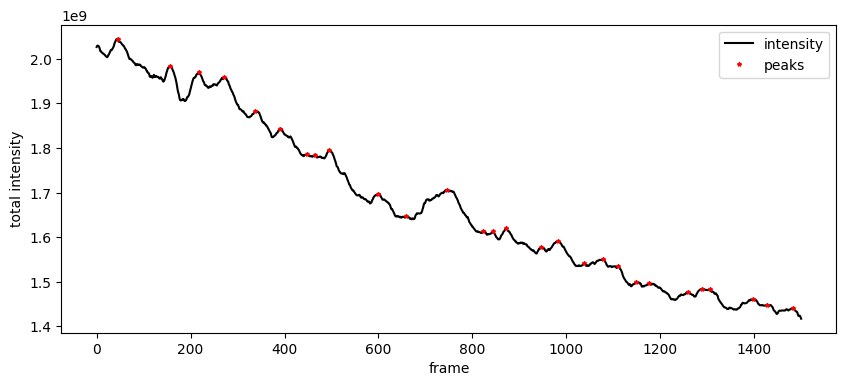

In [ ]:
%matplotlib inline
file_path = "astrotest-16x-LUT.tif"

stack = load_tiff(file_path)
mem_stack = memory_stack(stack)

peaks, intensities, sum_over_time = find_peaks(mem_stack)
plot_intensity_profile(intensities, peaks)

In [ ]:
def find_local_maxima(stack, peaks, grid_size=32):
    """
    finds local maxima in grid cells at peak frame

    parameters:
    stack (cp.array): 3D cupy array (height, width, time)
    peaks (np.array): frame numbers of peaks
    grid_size (int): size of grid cells

    returns:
    np.array: coordinates of maximum intensity pixels
    """
    height, width = stack.shape[:2]
    peak_frames = stack[:, :, peaks]
    first_peak = 0

    # initialize results array
    max_coords = []

    # iterate over grid cells
    for i in range(0, height, grid_size):
        for j in range(0, width, grid_size):
            # get cell boundaries
            i_end = min(i + grid_size, height)
            j_end = min(j + grid_size, width)

            # find maximum in cell
            cell = peak_frames[i:i_end, j:j_end, first_peak]
            max_idx = cp.unravel_index(cp.argmax(cell), cell.shape)

            # convert to global coordinates
            global_coords = (max_idx[0] + i, max_idx[1] + j)
            max_coords.append(global_coords)

    return cp.asnumpy(cp.array(max_coords))

In [ ]:
def find_local_maxima_vectorized(mem_stack, peaks, grid_size=32):
    """
    finds local maxima in grid cells at peak frame using vectorized operations

    parameters:
    mem_stack (cp.array): 3D cupy array (height, width, time)
    peaks (np.array): frame numbers of peaks
    grid_size (int): size of grid cells

    returns:
    np.array: coordinates of maximum intensity pixels
    """
    height, width, _ = mem_stack.shape
    peak_frame = mem_stack[:, :, peaks[0]]  # use the first peak frame

    # calculate number of complete cells in each dimension
    n_cells_h = height // grid_size
    n_cells_w = width // grid_size

    # reshape to (n_cells_h, grid_size, n_cells_w, grid_size)
    cells = peak_frame[:n_cells_h * grid_size, :n_cells_w * grid_size].reshape(n_cells_h, grid_size, n_cells_w, grid_size)
    cells = cells.transpose(0, 2, 1, 3)  # reorder to (n_cells_h, n_cells_w, grid_size, grid_size)

    # find local maxima in each cell
    max_indices = cp.argmax(cells.reshape(n_cells_h * n_cells_w, -1), axis=1)

    # convert to y,x coordinates within cells
    local_y = max_indices // grid_size
    local_x = max_indices % grid_size

    # calculate grid cell indices
    grid_row = cp.arange(n_cells_h)
    grid_col = cp.arange(n_cells_w)

    # convert to global coordinates
    global_y = (grid_row[:, None] * grid_size + local_y.reshape(n_cells_h, n_cells_w)).ravel()
    global_x = (grid_col[None, :] * grid_size + local_x.reshape(n_cells_h, n_cells_w)).ravel()

    # stack coordinates
    coords = cp.stack([global_y, global_x], axis=1)

    return cp.asnumpy(coords)

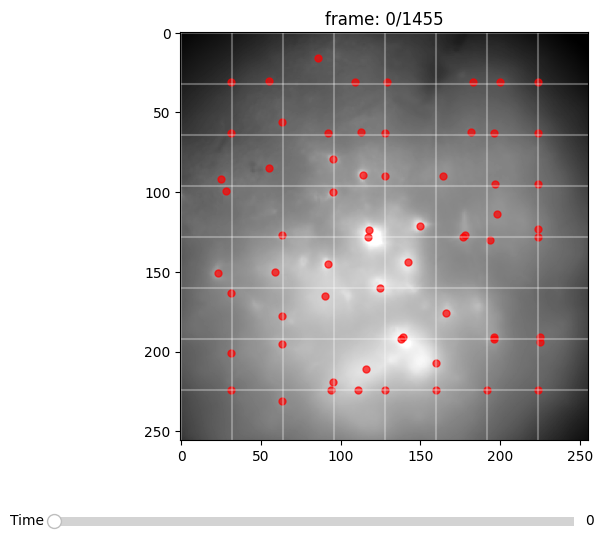

In [ ]:
%matplotlib inline
max_coords = find_local_maxima(mem_stack, peaks, grid_size=32)

show_stack(stack[peaks[0]:], init_coords=max_coords, grid_size=32)

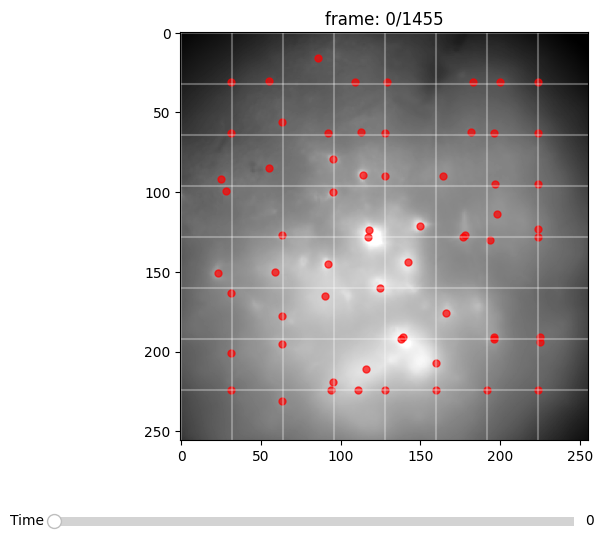

In [ ]:
max_coords = find_local_maxima_vectorized(mem_stack, peaks, grid_size=32)

show_stack(stack[peaks[0]:], init_coords=max_coords, grid_size=32)

In [ ]:
%timeit find_local_maxima(mem_stack, peaks, grid_size=32)


38 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%timeit find_local_maxima_vectorized(mem_stack, peaks, grid_size=32)

527 µs ± 4.73 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [ ]:
def cross_correlate_maxima_safe(mem_stack, max_coords, top_n=32):
    """
    computes cross-correlation of intensity profiles over time for top N maxima using raw kernels

    parameters:
    mem_stack (cp.array): 3D cupy array (height, width, time)
    max_coords (np.array): coordinates of maximum intensity pixels (y, x)
    top_n (int): number of top maxima to consider

    returns:
    np.array: cross-correlation matrix of shape (top_n, top_n)
    """
    # ensure top_n does not exceed the number of maxima
    top_n = min(top_n, len(max_coords))

    # extract intensity profiles for top N maxima
    y_coords, x_coords = max_coords[:top_n].T
    intensity_profiles = mem_stack[y_coords, x_coords, :].astype(cp.float32)

    # normalize intensity profiles
    intensity_profiles -= cp.mean(intensity_profiles, axis=1, keepdims=True)
    intensity_profiles /= cp.std(intensity_profiles, axis=1, keepdims=True)

    # prepare output array for cross-correlation
    cross_corr_matrix = cp.zeros((top_n, top_n), dtype=cp.float32)

    for i in range(top_n):
        for j in range(top_n):
            corr = cp.correlate(intensity_profiles[i], intensity_profiles[j], mode='valid')
            cross_corr_matrix[i, j] = corr

    cross_corr_matrix_np = cp.asnumpy(cross_corr_matrix)

    # calculate average excluding the maximum value of correlation with itself
    avg_corr_values = np.mean(cross_corr_matrix_np, axis=1) - np.max(cross_corr_matrix_np, axis=1)

    # pair average cross-correlation with coordinates
    corrcoef_coordinates = [(avg_corr_values[i], (y_coords[i], x_coords[i])) for i in range(top_n)]
    return cross_corr_matrix_np, corrcoef_coordinates

In [ ]:
def cross_correlate_maxima_kernel(mem_stack, max_coords, top_n=32):
    """
    computes cross-correlation of intensity profiles over time for top N maxima using raw kernels

    parameters:
    mem_stack (cp.array): 3D cupy array (height, width, time)
    max_coords (np.array): coordinates of maximum intensity pixels (y, x)
    top_n (int): number of top maxima to consider

    returns:
    list of tuples: [(average cross-correlation, coordinates of maxima), ...]
    """
    # ensure top_n does not exceed the number of maxima
    top_n = min(top_n, len(max_coords))

    # extract intensity profiles for top N maxima
    y_coords, x_coords = max_coords[:top_n].T
    intensity_profiles = mem_stack[y_coords, x_coords, :].astype(cp.float32)  # ensure float type

    # normalize intensity profiles
    intensity_profiles -= cp.mean(intensity_profiles, axis=1, keepdims=True)
    intensity_profiles /= cp.std(intensity_profiles, axis=1, keepdims=True)

    # prepare output array for cross-correlation
    cross_corr_matrix = cp.zeros((top_n, top_n), dtype=cp.float32)

    # define the raw kernel
    kernel_code = r'''
    extern "C" __global__ void cross_correlate(
        const float* profiles,
        float* cross_corr_matrix,
        int num_profiles,
        int time_length
    ) {
        int i = blockIdx.x;
        int j = threadIdx.x;

        if (i < num_profiles && j < num_profiles) {
            float sum = 0.0;
            for (int t = 0; t < time_length; ++t) {
                sum += profiles[i * time_length + t] * profiles[j * time_length + t];
            }
            cross_corr_matrix[i * num_profiles + j] = sum;
        }
    }
    '''

    # compile the kernel
    module = cp.RawModule(code=kernel_code)
    kernel = module.get_function('cross_correlate')

    # get the number of time points
    time_length = intensity_profiles.shape[1]

    # run the kernel
    kernel(
        (top_n,),  # number of blocks
        (top_n,),  # number of threads per block
        (intensity_profiles, cross_corr_matrix, top_n, time_length)
    )

    cross_corr_matrix_np = cp.asnumpy(cross_corr_matrix)

    # calculate average excluding the maximum value of correlation with itself
    avg_corr_values = np.mean(cross_corr_matrix_np, axis=1) - np.max(cross_corr_matrix_np, axis=1)

    # pair average cross-correlation with coordinates
    corrcoef_coordinates = [(avg_corr_values[i], (y_coords[i], x_coords[i])) for i in range(top_n)]
    return cross_corr_matrix_np, corrcoef_coordinates

In [ ]:
cross_corr_matrix_safe, _ = cross_correlate_maxima_safe(mem_stack, max_coords, top_n=64)
cross_corr_matrix_kernel, _ = cross_correlate_maxima_kernel(mem_stack, max_coords, top_n=64)
assert (cross_corr_matrix_kernel == cross_corr_matrix_safe).all()

AssertionError: 

In [ ]:
safe_matrix = cp.asnumpy(cross_corr_matrix_safe)
kernel_matrix = cp.asnumpy(cross_corr_matrix_kernel)

print(f"Mean for safe_function {np.mean(np.abs(safe_matrix))}, kernel {np.mean(np.abs(kernel_matrix))} ")
print(f"Mean absolute difference: {np.mean(np.abs(safe_matrix - kernel_matrix))}")
print(f"Max absolute difference: {np.max(np.abs(safe_matrix - kernel_matrix))}")

Mean for safe_function 1253.108154296875, kernel 1253.1083984375 
Mean absolute difference: 0.0006444156169891357
Max absolute difference: 0.00341796875


In [ ]:
from cupyx.profiler import benchmark
print(benchmark(cross_correlate_maxima_safe, (mem_stack, max_coords), n_repeat=10))
print(benchmark(cross_correlate_maxima_kernel, (mem_stack, max_coords), n_repeat=10))

cross_correlate_maxima_safe:    CPU: 298994.230 us   +/- 9575.789 (min: 289314.734 / max: 320183.633) us     GPU-0: 299015.445 us   +/- 9575.977 (min: 289336.975 / max: 320205.261) us
cross_correlate_maxima_kernel:    CPU:   800.382 us   +/- 42.766 (min:   767.028 / max:   919.465) us     GPU-0:   810.742 us   +/- 45.410 (min:   777.632 / max:   938.432) us


In [ ]:
def plot_cross_correlation(cross_corr_matrix):
    """
    plots the cross-correlation matrix

    parameters:
    cross_corr_matrix (np.array): cross-correlation matrix of shape (top_n, top_n)
    """
    plt.figure(figsize=(8, 8))
    plt.imshow(cross_corr_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Cross-Correlation')
    plt.title('Cross-Correlation Matrix of Top N Maxima')
    plt.xlabel('Maxima Index')
    plt.ylabel('Maxima Index')
    plt.show()

In [ ]:
def normalize_corrcoefs(corrcoefs):
    """
    normalizes correlation coefficients to [0, 1] range

    parameters:
    corrcoefs (cp.array): array of correlation coefficients

    returns:
    cp.array: normalized correlation coefficients
    """
    # ensure array type
    corrcoefs = cp.asarray(corrcoefs)

    # handle case where all values are the same
    if cp.max(corrcoefs) == cp.min(corrcoefs):
        return cp.ones_like(corrcoefs)

    # normalize to [0, 1]
    normalized = (corrcoefs - cp.min(corrcoefs)) / (cp.max(corrcoefs) - cp.min(corrcoefs))

    return normalized

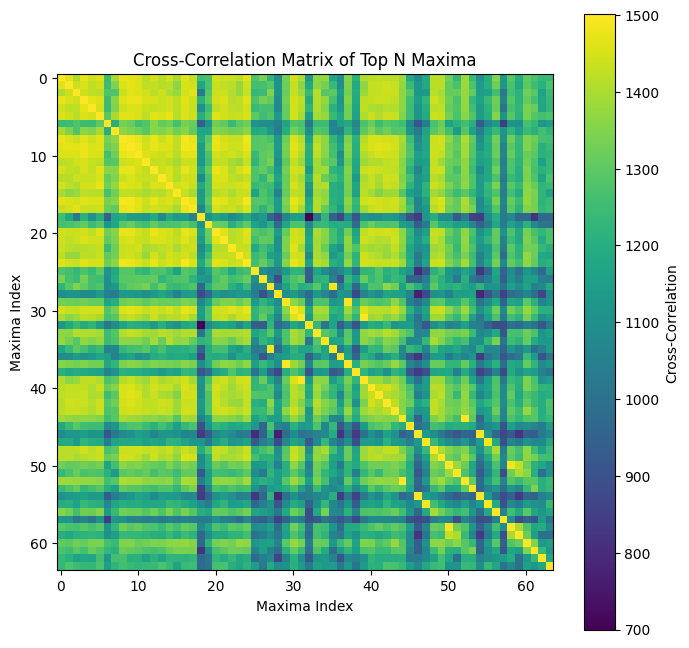

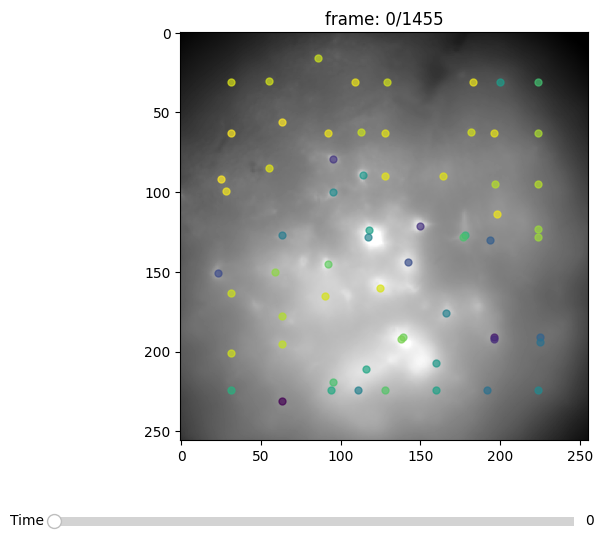

In [ ]:
cross_corr_matrix, corrcoef_coordinates = cross_correlate_maxima_kernel(mem_stack, max_coords, top_n=64)
plot_cross_correlation(cross_corr_matrix)

avg_corr_values, top_max_coords = zip(*corrcoef_coordinates)
norm_corr_values = normalize_corrcoefs(avg_corr_values)
all_neighbor_coords = []
all_neighbor_corrs = []

for init_coord in filtered_coords:
    neighbors = results[tuple(init_coord)]
    corr_values, coords = zip(*neighbors)
    all_neighbor_coords.extend(coords)
    all_neighbor_corrs.extend(corr_values)

# Convert to numpy arrays
all_neighbor_coords_array = np.array(all_neighbor_coords)
all_neighbor_corrs_array = np.array(all_neighbor_corrs)

# Visualize all neighbors
show_stack(stack[peaks[0]:], init_coords=all_neighbor_coords_array,
           avg_corr_values=all_neighbor_corrs_array)

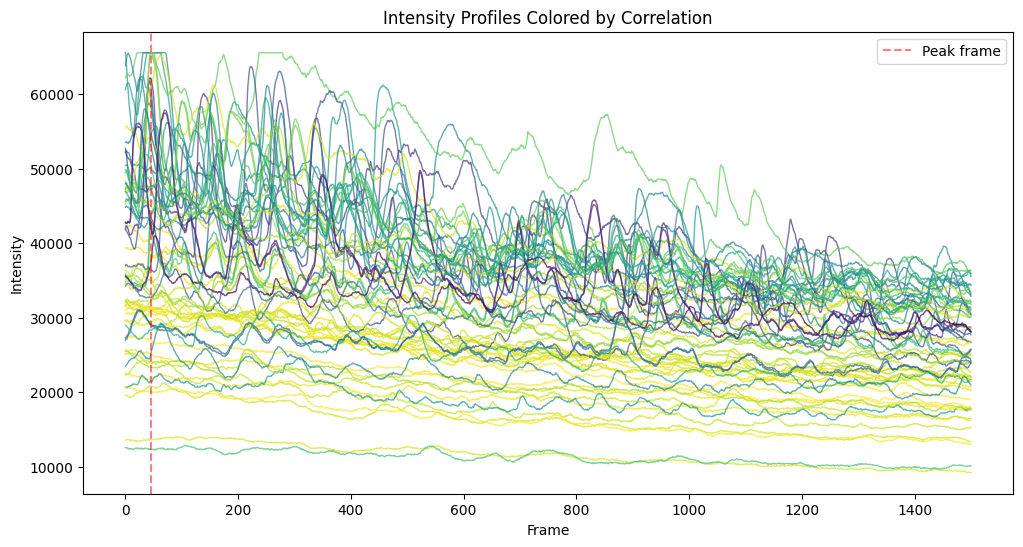

In [ ]:
def plot_intensity_profiles(mem_stack, max_coords, avg_corr_values, peaks):
    """
    plots all intensity profiles colored by their correlation coefficients

    parameters:
    mem_stack (cp.array): 3D array (height, width, time)
    max_coords (np.array): coordinates of maxima
    avg_corr_values (np.array): correlation coefficients for each profile
    peaks (np.array): peak frame numbers
    """
    # Extract intensity profiles
    y_coords, x_coords = zip(*max_coords)
    intensity_profiles = cp.asnumpy(mem_stack[y_coords, x_coords, :])

    # Create figure
    plt.figure(figsize=(12, 6))

    # Create colormap based on correlation coefficients
    colors = plt.cm.viridis(avg_corr_values)

    # Plot each profile
    for profile, color in zip(intensity_profiles, colors):
        plt.plot(profile, color=color, alpha=0.7, linewidth=1)

    # Add vertical line for peak frame
    plt.axvline(x=peaks[0], color='r', linestyle='--', alpha=0.5, label='Peak frame')

    plt.xlabel('Frame')
    plt.ylabel('Intensity')
    plt.title('Intensity Profiles Colored by Correlation')
    plt.legend()
    plt.show()

plot_intensity_profiles(mem_stack, top_max_coords, norm_corr_values, peaks)

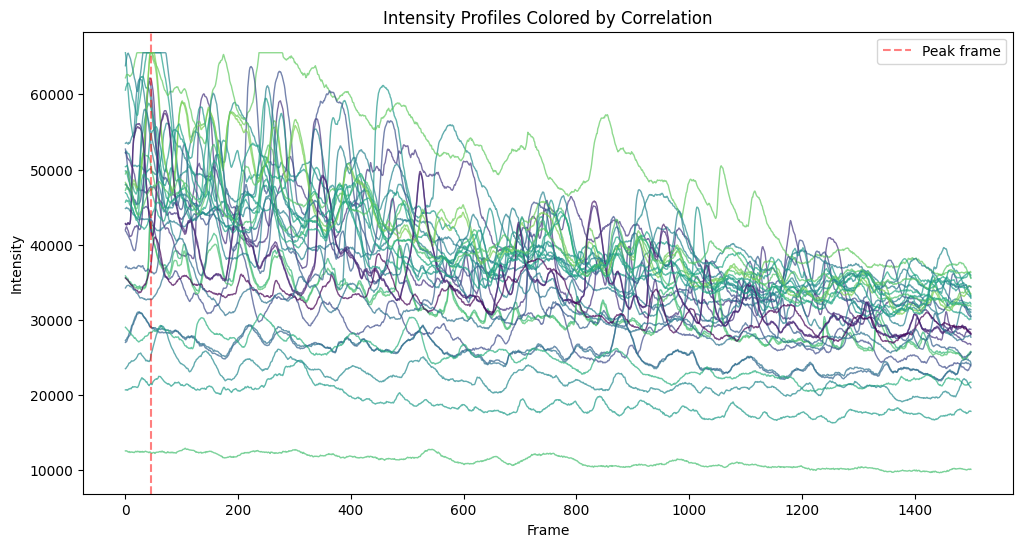

In [ ]:
global_corr_threshold = 0.8
mask = cp.asnumpy(norm_corr_values) < global_corr_threshold

filtered_coords = np.array(top_max_coords)[mask]
filtered_corr_values = cp.asnumpy(norm_corr_values)[mask]

plot_intensity_profiles(mem_stack, filtered_coords, filtered_corr_values, peaks)

In [ ]:
def adventurer(mem_stack, init_coords, how_far=3, grid_step=4):
    """
    explores and correlates neighboring coordinates for each initial coordinate

    parameters:
    mem_stack (cp.array): 3D cupy array (height, width, time)
    init_coords (np.array): initial coordinates to explore from [(y1,x1), (y2,x2), ...]
    how_far (int): how many grid steps to explore in each direction
    grid_step (int): size of each step in pixels (default=4)

    returns:
    dict: mapping of initial coordinates to their neighbors' correlation values
        {(y,x): [(corr_val, (neighbor_y, neighbor_x)), ...], ...}
    """
    height, width, _ = mem_stack.shape
    exploration_results = {}

    # Create grid offsets
    range_vals = np.arange(-how_far, how_far + 1) * grid_step
    y_offsets, x_offsets = np.meshgrid(range_vals, range_vals)
    offsets = np.column_stack((y_offsets.ravel(), x_offsets.ravel()))

    for init_y, init_x in init_coords:
        # generate neighbor coordinates
        neighbor_coords = np.array([(init_y + dy, init_x + dx) for dy, dx in offsets])

        # filter out coordinates outside image bounds
        valid_mask = (
            (neighbor_coords[:, 0] >= 0) &
            (neighbor_coords[:, 0] < height) &
            (neighbor_coords[:, 1] >= 0) &
            (neighbor_coords[:, 1] < width)
        )
        valid_neighbors = neighbor_coords[valid_mask]

        # extract intensity profiles
        y_coords, x_coords = valid_neighbors.T
        profiles = mem_stack[y_coords, x_coords, :].astype(cp.float32)
        init_profile = mem_stack[init_y, init_x, :].astype(cp.float32)

        # normalize profiles
        profiles -= cp.mean(profiles, axis=1, keepdims=True)
        profiles /= cp.std(profiles, axis=1, keepdims=True)
        init_profile -= cp.mean(init_profile)
        init_profile /= cp.std(init_profile)

        # prepare output array
        correlations = cp.zeros(len(valid_neighbors), dtype=cp.float32)

        # define correlation kernel
        kernel_code = r'''
        extern "C" __global__ void correlate_profiles(
            const float* profiles,
            const float* init_profile,
            float* correlations,
            int num_profiles,
            int time_length
        ) {
            int idx = blockIdx.x * blockDim.x + threadIdx.x;

            if (idx < num_profiles) {
                float sum = 0.0;
                for (int t = 0; t < time_length; ++t) {
                    sum += profiles[idx * time_length + t] * init_profile[t];
                }
                correlations[idx] = sum;
            }
        }
        '''

        # compile and run kernel
        module = cp.RawModule(code=kernel_code)
        kernel = module.get_function('correlate_profiles')

        threads_per_block = 256
        blocks = (len(valid_neighbors) + threads_per_block - 1) // threads_per_block

        kernel(
            (blocks,),
            (threads_per_block,),
            (profiles, init_profile, correlations, len(valid_neighbors), profiles.shape[1])
        )

        corrcoef_coordinates = list(zip(
            cp.asnumpy(correlations),
            valid_neighbors
        ))

        # Normalize correlation values
        corr_values, coords = zip(*corrcoef_coordinates)
        norm_corr_values = cp.asnumpy(normalize_corrcoefs(cp.array(corr_values)))
        norm_corr_values = cp.asnumpy(norm_corr_values)

        # Store results
        exploration_results[(init_y, init_x)] = list(zip(norm_corr_values, coords))

    return exploration_results


In [ ]:
adventurer_findings = adventurer(mem_stack, filtered_coords)

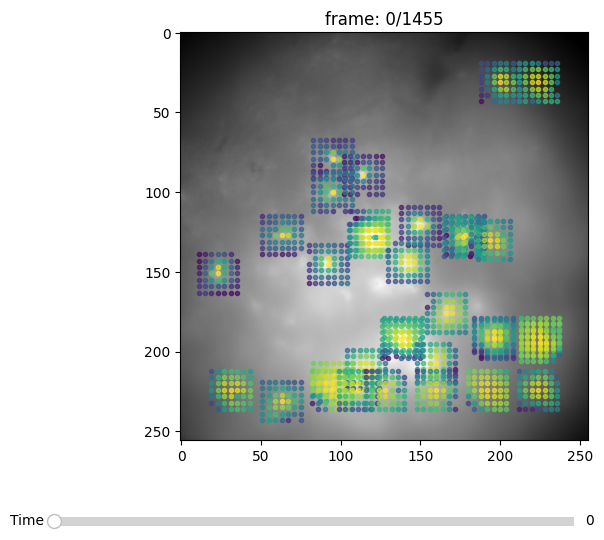

In [ ]:
all_neighbor_coords = []
all_neighbor_corrs = []
threshold = 0.0

for init_coord in filtered_coords:
    neighbors = adventurer_findings[tuple(init_coord)]
    corr_values, coords = zip(*neighbors)

    mask = np.array(corr_values) > threshold
    coords = np.array(coords)[mask]
    corr_values = np.array(corr_values)[mask]

    all_neighbor_coords.extend(coords)
    all_neighbor_corrs.extend(corr_values)

# Convert to numpy arrays
all_neighbor_coords_array = np.array(all_neighbor_coords)
all_neighbor_corrs_array = np.array(all_neighbor_corrs)

# Visualize all neighbors
show_stack(stack[peaks[0]:], init_coords=all_neighbor_coords_array,
           avg_corr_values=all_neighbor_corrs_array,marker=3)

In [ ]:
high_corr_coords = []
for init_coord in filtered_coords:
    neighbors = adventurer_findings[tuple(init_coord)]
    corr_values, coords = zip(*neighbors)

    # Get coordinates with high correlation
    mask = np.array(corr_values) > 0.6
    high_corr_coords.extend(np.array(coords)[mask])

# Remove duplicates if any
high_corr_coords = np.unique(high_corr_coords, axis=0)
print(f"Found {len(high_corr_coords)} high correlation points to explore")

# Run fine-grained adventurer on these coordinates
fine_adventurer_findings = adventurer(mem_stack, high_corr_coords, how_far=4, grid_step=1)

# Collect all fine-grained neighbors and their correlations
all_fine_coords = []
all_fine_corrs = []

for init_coord in high_corr_coords:
    neighbors = fine_adventurer_findings[tuple(init_coord)]
    corr_values, coords = zip(*neighbors)

    # Filter by correlation threshold
    mask = np.array(corr_values) > 0.7
    hfiltered_coords = np.array(coords)[mask]
    hfiltered_corrs = np.array(corr_values)[mask]

    all_fine_coords.extend(hfiltered_coords)
    all_fine_corrs.extend(hfiltered_corrs)

# Visualize the filtered fine-grained exploration

Found 772 high correlation points to explore


In [ ]:
print(benchmark(adventurer, (mem_stack, filtered_coords), n_repeat=10))

adventurer          :    CPU: 58099.352 us   +/- 4780.268 (min: 49333.490 / max: 63957.613) us     GPU-0: 58118.335 us   +/- 4779.978 (min: 49362.946 / max: 63976.063) us


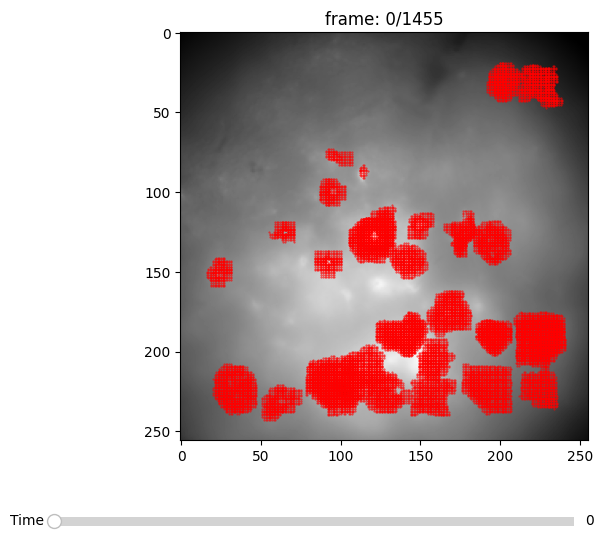

In [ ]:
show_stack(stack[peaks[0]:], init_coords=np.array(all_fine_coords),
           avg_corr_values=None, marker=1)